In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Lambda
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model

In [2]:
# Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print info
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Format dataset 
H, W = x_train.shape[1], x_train.shape[2]

# 3 channels for CNN
x_train = x_train.reshape((-1, H, W, 1))
x_test  = x_test.reshape((-1, H, W, 1))

# Binary images to use bce as reconstruction loss
x_train = np.round(x_train.astype('float32') / 255.)
x_test  = np.round(x_test.astype('float32') / 255.)

# Print info
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


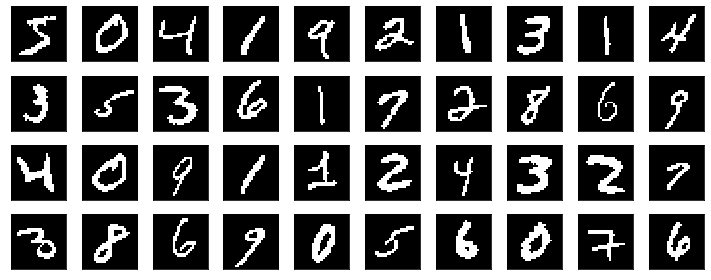

In [4]:
# Show a few examples
plt.figure(figsize=(10, 4))
for i in range(40):
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(x_train[i].reshape(H, W), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

# Create VCAE

In [15]:
# -- PARAMETERS -- 
batch_size = 100
latent_shape = (batch_size, 4, 4, 1) # number of components and shape in the latent space

In [16]:
# Sampling function with reparametrization trick
def sampling_z(args):
    mean, var = args
    epsilon = tf.random.normal(shape=latent_shape)
    return mean + tf.exp(0.5 * var) * epsilon

In [17]:
# Q(z|x) -- Define encoder
in_layer = Input(shape=x_train.shape[1:], name='INPUT')

h_q = Conv2D(256, 3, strides=2, activation='relu', padding='same', name='H_Q')(in_layer)
h_q = Conv2D(128, 3, strides=2, activation='relu', padding='same')(h_q)
h_q = Conv2D( 64, 3, strides=2, activation='relu', padding='same')(h_q)

# Latent representation
mu        = Conv2D(latent_shape[-1], 2, activation='linear', padding='same', name='MU')(h_q)
log_sigma = Conv2D(latent_shape[-1], 2, activation='linear', padding='same', name='SIGMA')(h_q)
z = Lambda(sampling_z, name='Z')([mu, log_sigma])

# Final encoder
encoder = Model(in_layer, z, name='ENCODER')
encoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
H_Q (Conv2D)                    (None, 14, 14, 256)  2560        INPUT[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 128)    295040      H_Q[0][0]                        
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 4, 4, 64)     73792       conv2d_4[0][0]                   
____________________________________________________________________________________________

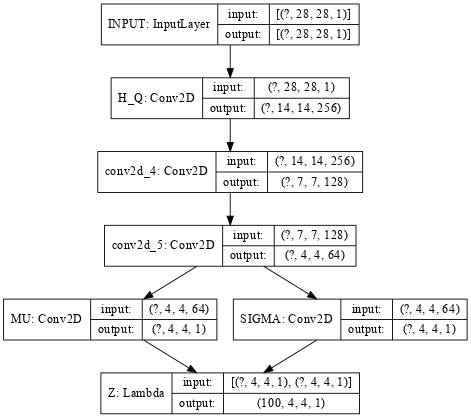

In [18]:
# Plot model
plot_model(encoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [23]:
# P(x|z) -- Define decoder
dec_in_layer = Input(shape=latent_shape[1:], name='IN_DECOD')

h_q = Conv2DTranspose( 64, 3, strides=2, padding='same', activation='relu')(dec_in_layer)
h_q = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(h_q)
h_q = Conv2D(128, 3, activation='relu')(h_q)
h_q = Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu', name='H_P')(h_q)
dec_out_layer = Conv2D(1, 3, padding='same', activation='sigmoid', name='OUT')(h_q)

# Final decoder
decoder = Model(dec_in_layer, dec_out_layer, name='DECODER')
decoder.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IN_DECOD (InputLayer)        [(None, 4, 4, 1)]         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 64)          640       
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
H_P (Conv2DTranspose)        (None, 28, 28, 256)       295168    
_________________________________________________________________
OUT (Conv2D)                 (None, 28, 28, 1)         2305      
Total params: 519,553
Trainable params: 519,553
Non-trainable params: 0
_____________________________________________________

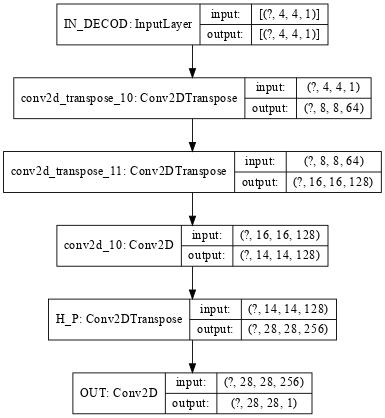

In [24]:
# Plot model
plot_model(decoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [25]:
# Create full Conv Variational Autoencoder
out_layer = decoder(encoder(in_layer))
cvae = Model(in_layer, out_layer, name='CVAE')
cvae.summary()

Model: "CVAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
ENCODER (Model)              (100, 4, 4, 1)            371906    
_________________________________________________________________
DECODER (Model)              multiple                  519553    
Total params: 891,459
Trainable params: 891,459
Non-trainable params: 0
_________________________________________________________________


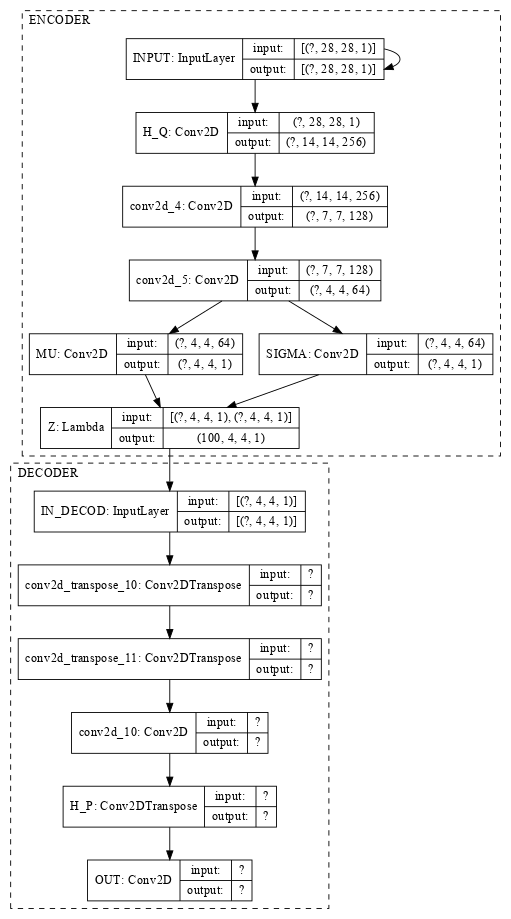

In [26]:
# Plot model
plot_model(cvae, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [27]:
# AUX -- VAE custom loss (DKL + BCE)
def vae_loss(x, x_hat):
    # E[log P(X|z)] - BCE
    reconst = binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat))
    # D_KL(Q(z|X) || P(z|X))
    dkl = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=-1)
    return reconst + 3e-5 * dkl

In [28]:
# Compile and train model
cvae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)
history = cvae.fit(x_train, x_train, epochs=10, batch_size=batch_size, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 561s 10ms/sample - loss: 0.1692 - val_loss: 0.1210
Epoch 2/10
54000/54000 [==============================] - 772s 14ms/sample - loss: 0.1128 - val_loss: 0.1050
Epoch 3/10
54000/54000 [==============================] - 792s 15ms/sample - loss: 0.1031 - val_loss: 0.0988
Epoch 4/10
54000/54000 [==============================] - 590s 11ms/sample - loss: 0.0979 - val_loss: 0.0946
Epoch 5/10
54000/54000 [==============================] - 539s 10ms/sample - loss: 0.0943 - val_loss: 0.0920
Epoch 6/10
54000/54000 [==============================] - 30071s 557ms/sample - loss: 0.0918 - val_loss: 0.0902
Epoch 7/10
54000/54000 [==============================] - 678s 13ms/sample - loss: 0.0898 - val_loss: 0.0885
Epoch 8/10
54000/54000 [==============================] - 719s 13ms/sample - loss: 0.0881 - val_loss: 0.0869
Epoch 9/10
54000/54000 [==============================] - 689s 13ms/sample -

10000/10000 [==============================] - 43s 4ms/sample - loss: 0.0841


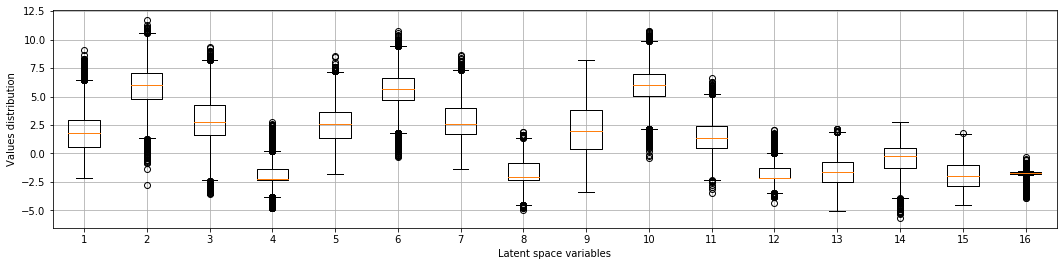

In [35]:
# Compute latent representation for test data, and see its latent space
cvae.evaluate(x_test, x_test, batch_size=batch_size)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(18, 4))
plt.boxplot(x_test_encoded.reshape((len(x_test_encoded), -1)))
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

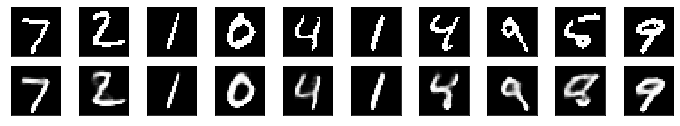

In [36]:
# Reconstruct and show a few examples
x_test_hat = decoder.predict(x_test_encoded, batch_size=batch_size)

plt.figure(figsize=(12, 2))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(H, W), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(x_test_hat[i].reshape(H, W), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
# Compute mean and stdd of latent space from training set
x_train_encoded = encoder.predict(x_train, batch_size=batch_size).reshape((len(x_train), -1))
x_train_enc_mean = x_train_encoded.mean(axis=0)
x_train_enc_stdd = x_train_encoded.std(axis=0)

In [38]:
# Uniform sampling over each latent dimension within mean \pm stdd
n_points = 1000
z_samples = np.zeros((n_points, len(x_train_enc_mean)))
for ind_z in range(len(x_train_enc_mean)):
    low = x_train_enc_mean[..., ind_z] - x_train_enc_stdd[..., ind_z]
    hig = x_train_enc_mean[..., ind_z] + x_train_enc_stdd[..., ind_z]
    z_samples[:, ind_z] = np.random.uniform(low=low, high=hig, size=(n_points,))

print(z_samples.shape)

(1000, 16)


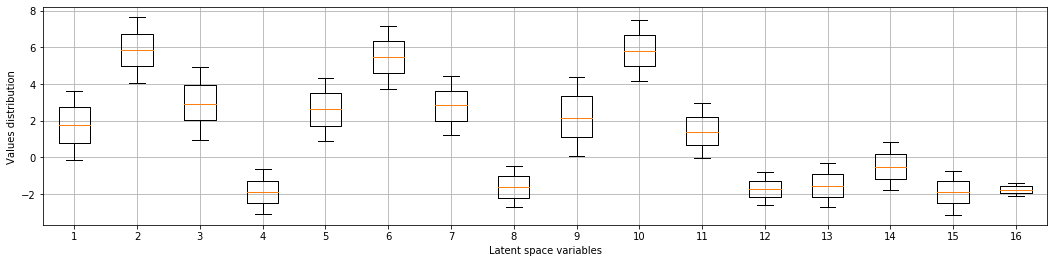

In [39]:
# Compare distribution of synthetic z samples with the estimated distribution
plt.figure(figsize=(18, 4))
plt.boxplot(z_samples)
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

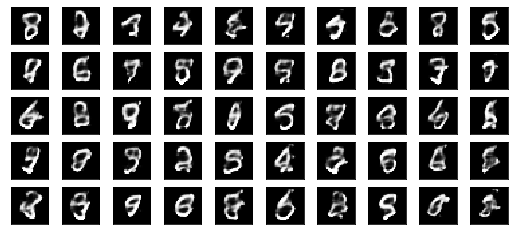

In [40]:
# Map uniform sampling to output space
z_samples = z_samples.reshape((n_points, latent_shape[1], latent_shape[2], latent_shape[3]))
x_samples_hat = decoder.predict(z_samples)

# Show a few reconstruction from random samples
plt.figure(figsize=(9, 4))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    plt.imshow(x_samples_hat[i].reshape(H, W), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()